In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset
from torch.autograd import Variable
import os,cv2
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
torch.autograd.set_detect_anomaly(True)
from torchvision.utils import make_grid 
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os
runningFromColab = False
if 'CGROUP_MEMORY_EVENTS' in os.environ and 'colab' in os.environ['CGROUP_MEMORY_EVENTS']:
  runningFromColab = True
if runningFromColab:
  from google.colab import drive
  drive.mount('/content/drive')
if runningFromColab:
  %cd /content/drive/MyDrive/WaterCrystal/final_project/dl-water-crystals-synthesis-super-resolution

Mounted at /content/drive
/content/drive/MyDrive/WaterCrystal/final_project/dl-water-crystals-synthesis-super-resolution


In [3]:
if runningFromColab:
  !pip install huggingface-hub
  !pip install datasets
  !pip install diffusers[training]==0.11.1
  !pip install accelerate
  !pip install Augmentor
  # install Git-LFS to upload the model checkpoints
  !sudo apt -qq install git-lfs
  !git config --global credential.helper store

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 24.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [4]:
class waterCrtystals(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform=transform
    def __len__(self):
        return len([entry for entry in os.listdir(self.root) if os.path.isfile(os.path.join(self.root, entry))])

    def __getitem__(self, idx):
        for i, img in enumerate(os.listdir(self.root)):
            img = cv2.imread(os.path.join(f'{self.root}/{img}'))
            if self.transform:
                img = self.transform(img)
            if i == idx:
                return img,idx


def dataloader(batch_size):
  dataroot="dataset/Microparticle"
  transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(128),transforms.CenterCrop(128),transforms.Normalize((0),(1))])
  dataset=waterCrtystals(root=dataroot,transform=transform)
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return data_loader
    

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.conv1=nn.Conv2d(3,64,5,padding=2,stride=2)   #in_channels=3
    self.bn1=nn.BatchNorm2d(64,momentum=0.9)
    self.conv2=nn.Conv2d(64,128,5,padding=2,stride=2)
    self.bn2=nn.BatchNorm2d(128,momentum=0.9)
    self.conv3=nn.Conv2d(128,256,5,padding=2,stride=2)
    self.bn3=nn.BatchNorm2d(256,momentum=0.9)
    self.relu=nn.LeakyReLU(0.2)
    self.fc1=nn.Linear(256*16*16,2048)
    self.bn4=nn.BatchNorm1d(2048,momentum=0.9)
    self.fc_mean=nn.Linear(2048,128)
    self.fc_logvar=nn.Linear(2048,128)   #latent dim=128
  
  def forward(self,x):
    batch_size=x.size()[0]
    out=self.relu(self.bn1(self.conv1(x)))
    out=self.relu(self.bn2(self.conv2(out)))
    out=self.relu(self.bn3(self.conv3(out)))
    out=out.view(batch_size,-1)
    out=self.relu(self.bn4(self.fc1(out)))
    mean=self.fc_mean(out)
    logvar=self.fc_logvar(out)
    
    return mean,logvar
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.fc1=nn.Linear(128,16*16*256)
    self.bn1=nn.BatchNorm1d(16*16*256,momentum=0.9)
    self.relu=nn.LeakyReLU(0.2)
    self.deconv1=nn.ConvTranspose2d(256,256,6, stride=2, padding=2)
    self.bn2=nn.BatchNorm2d(256,momentum=0.9)
    self.deconv2=nn.ConvTranspose2d(256,128,6, stride=2, padding=2)
    self.bn3=nn.BatchNorm2d(128,momentum=0.9)
    self.deconv3=nn.ConvTranspose2d(128,32,6, stride=2, padding=2)
    self.bn4=nn.BatchNorm2d(32,momentum=0.9)
    self.deconv4=nn.ConvTranspose2d(32,3,5, stride=1, padding=2)
    self.tanh=nn.Tanh()

  def forward(self,x):
    batch_size=x.size()[0]
    x=self.relu(self.bn1(self.fc1(x)))
    x=x.view(-1,256,16,16)
    x=self.relu(self.bn2(self.deconv1(x)))
    x=self.relu(self.bn3(self.deconv2(x)))
    x=self.relu(self.bn4(self.deconv3(x)))
    x=self.tanh(self.deconv4(x))
    return x
  
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1=nn.Conv2d(3,32,5,padding=2,stride=1)
    self.relu=nn.LeakyReLU(0.2)
    self.conv2=nn.Conv2d(32,128,5,padding=2,stride=2)
    self.bn1=nn.BatchNorm2d(128,momentum=0.9)
    self.conv3=nn.Conv2d(128,256,5,padding=2,stride=2)
    self.bn2=nn.BatchNorm2d(256,momentum=0.9)
    self.conv4=nn.Conv2d(256,256,5,padding=2,stride=2)
    self.bn3=nn.BatchNorm2d(256,momentum=0.9)
    self.fc1=nn.Linear(16*16*256,512)
    self.bn4=nn.BatchNorm1d(512,momentum=0.9)
    self.fc2=nn.Linear(512,1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    batch_size=x.size()[0]
    x=self.relu(self.conv1(x))
    x=self.relu(self.bn1(self.conv2(x)))
    x=self.relu(self.bn2(self.conv3(x)))
    x=self.relu(self.bn3(self.conv4(x)))
    x=x.view(-1,256*16*16)
    x1=x;
    x=self.relu(self.bn4(self.fc1(x)))
    x=self.sigmoid(self.fc2(x))

    return x,x1
class VAE_GAN(nn.Module):
  def __init__(self):
    super(VAE_GAN,self).__init__()
    self.encoder=Encoder()
    self.decoder=Decoder()
    self.discriminator=Discriminator()
    self.encoder.apply(weights_init)
    self.decoder.apply(weights_init)
    self.discriminator.apply(weights_init)


  def forward(self,x):
    bs=x.size()[0]
    z_mean,z_logvar=self.encoder(x)
    std = z_logvar.mul(0.5).exp_()
        
    #sampling epsilon from normal distribution
    epsilon=Variable(torch.randn(bs,128)).to(device)
    z=z_mean+std*epsilon
    x_tilda=self.decoder(z)
      
    return z_mean,z_logvar,x_tilda
    

In [6]:
def show_and_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "generated-VAEGANs/%s.png" % file_name
    fig = plt.figure(dpi=200)
    fig.suptitle(file_name, fontsize=14, fontweight='bold')
    #plt.imshow(npimg)
    plt.imsave(f,npimg)
def plot_loss(loss_list):
    plt.figure(figsize=(10,5))
    plt.title("Loss During Training")
    plt.plot(loss_list,label="Loss")
    
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [7]:
# scale an array of images to a new size
def scale_images(images, new_shape):
 images_list = list()
 for image in images:
       # resize with nearest neighbor interpolation
       new_image = resize(image, new_shape, 0)
       # store
       images_list.append(new_image)
 return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
 # calculate activations
 act1 = model.predict(images1)
 act2 = model.predict(images2)
 # calculate mean and covariance statistics
 mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
 mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
 # calculate sum squared difference between means
 ssdiff = np.sum((mu1 - mu2)**2.0)
 # calculate sqrt of product between cov
 covmean = sqrtm(sigma1.dot(sigma2))
 # check and correct imaginary numbers from sqrt
 if iscomplexobj(covmean):
        covmean = covmean.real
 # calculate score
 fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
 return fid


In [8]:
#TEST

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(128,128,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (128,128,3))
images2 = scale_images(images2, (128,128,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)

87910968/87910968 [==============================] - 4s 0us/step
Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 128, 128, 3) (10, 128, 128, 3)
1/1 [==============================] - 0s 32ms/step
FID (same): -0.001
1/1 [==============================] - 0s 39ms/step


In [12]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(128,128,3))
data_loader=dataloader(20)
gen=VAE_GAN().to(device)
discrim=Discriminator().to(device)
real_batch = next(iter(data_loader))

c:\Users\Shehab\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[0/100][0/8]	Loss_gan: 3.8612	Loss_prior: 0.1299	Rec_loss: 0.6677	dis_real_loss: 1.0504	dis_fake_loss: 1.3410	dis_prior_loss: 1.4699
[1/100][0/8]	Loss_gan: 2.0361	Loss_prior: 1.3600	Rec_loss: 0.3997	dis_real_loss: 0.6877	dis_fake_loss: 0.6844	dis_prior_loss: 0.6640
[2/100][0/8]	Loss_gan: 2.2258	Loss_prior: 0.2926	Rec_loss: 0.2894	dis_real_loss: 0.7403	dis_fake_loss: 0.6838	dis_prior_loss: 0.8017
[3/100][0/8]	Loss_gan: 1.9078	Loss_prior: 0.3099	Rec_loss: 0.2715	dis_real_loss: 0.7249	dis_fake_loss: 0.6061	dis_prior_loss: 0.5769
[4/100][0/8]	Loss_gan: 1.9263	Loss_prior: 0.2164	Rec_loss: 0.2164	dis_real_loss: 0.7498	dis_fake_loss: 0.5908	dis_prior_loss: 0.5857
[5/100][0/8]	Loss_gan: 1.8413	Loss_prior: 0.3789	Rec_loss: 0.2410	dis_real_loss: 0.7609	dis_fake_loss: 0.5550	dis_prior_loss: 0.5254
[6/100][0/8]	Loss_gan: 1.7581	Loss_prior: 0.1609	Rec_loss: 0.2721	dis_real_loss: 0.7081	dis_fake_loss: 0.5340	dis_prior_loss: 0.5160
[7/100][0/8]	Loss_gan: 1.6643	Loss_prior: 0.1986	Rec_loss: 0.2642	dis

C:\Users\Shehab\AppData\Local\Temp\ipykernel_16152\356769395.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(dpi=200)


[10/100][0/8]	Loss_gan: 1.6982	Loss_prior: 0.1538	Rec_loss: 0.2540	dis_real_loss: 0.7653	dis_fake_loss: 0.4845	dis_prior_loss: 0.4484
[11/100][0/8]	Loss_gan: 1.8544	Loss_prior: 0.2936	Rec_loss: 0.2407	dis_real_loss: 0.9156	dis_fake_loss: 0.4892	dis_prior_loss: 0.4496
[12/100][0/8]	Loss_gan: 1.6123	Loss_prior: 0.2596	Rec_loss: 0.2673	dis_real_loss: 0.7112	dis_fake_loss: 0.4744	dis_prior_loss: 0.4267
[13/100][0/8]	Loss_gan: 1.9308	Loss_prior: 0.2225	Rec_loss: 0.2386	dis_real_loss: 0.9329	dis_fake_loss: 0.4640	dis_prior_loss: 0.5339
[14/100][0/8]	Loss_gan: 1.6530	Loss_prior: 0.2158	Rec_loss: 0.2761	dis_real_loss: 0.7793	dis_fake_loss: 0.4605	dis_prior_loss: 0.4132
[15/100][0/8]	Loss_gan: 1.8243	Loss_prior: 0.2101	Rec_loss: 0.2282	dis_real_loss: 0.8291	dis_fake_loss: 0.4900	dis_prior_loss: 0.5053
[16/100][0/8]	Loss_gan: 1.5662	Loss_prior: 0.2186	Rec_loss: 0.2866	dis_real_loss: 0.7382	dis_fake_loss: 0.4235	dis_prior_loss: 0.4044
[17/100][0/8]	Loss_gan: 1.5556	Loss_prior: 0.2738	Rec_loss: 0.

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

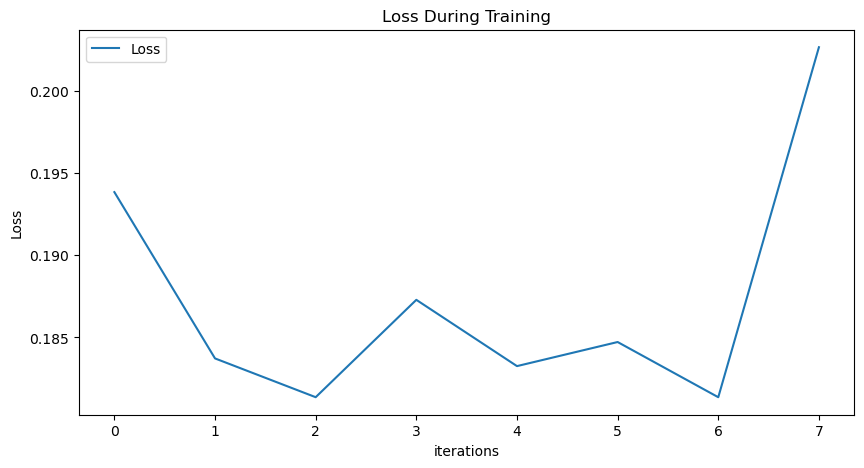

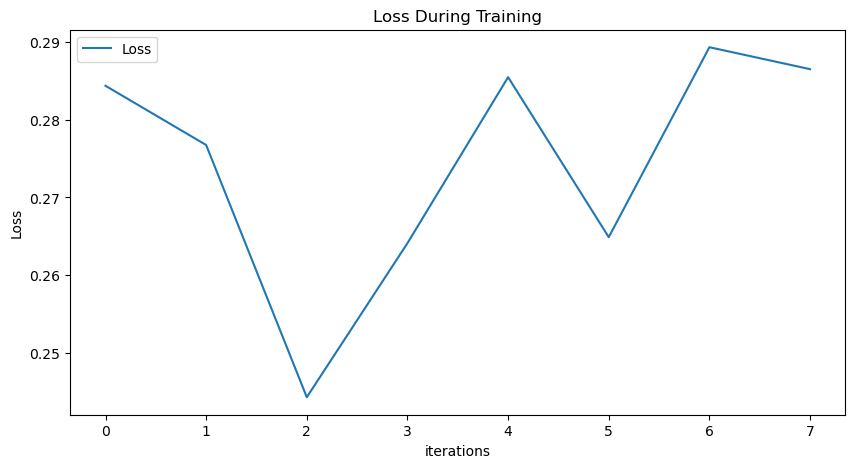

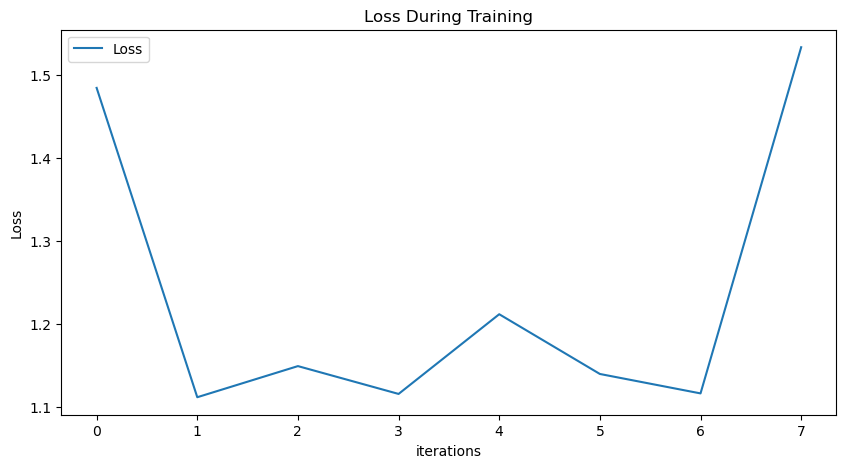

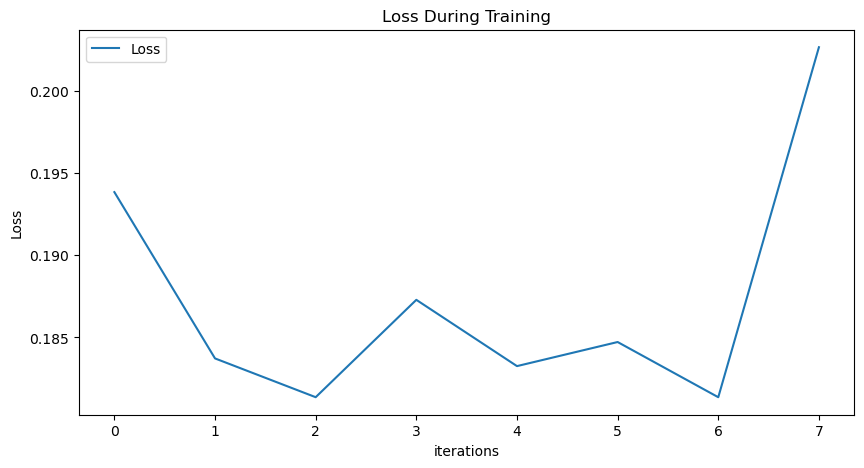

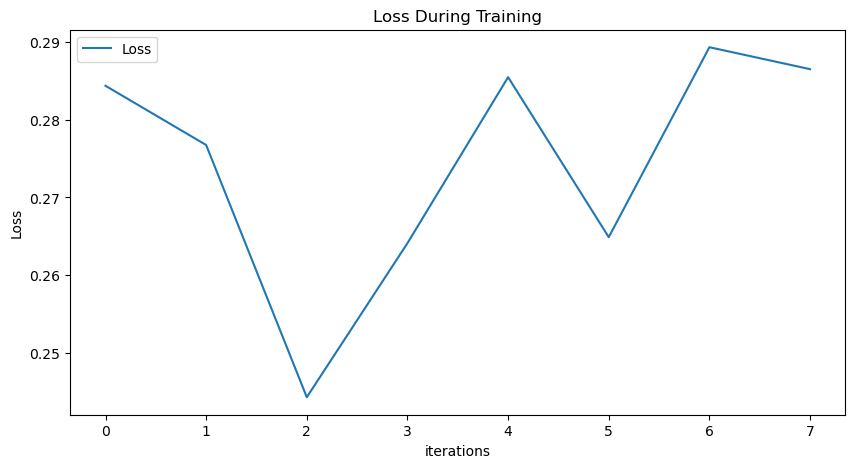

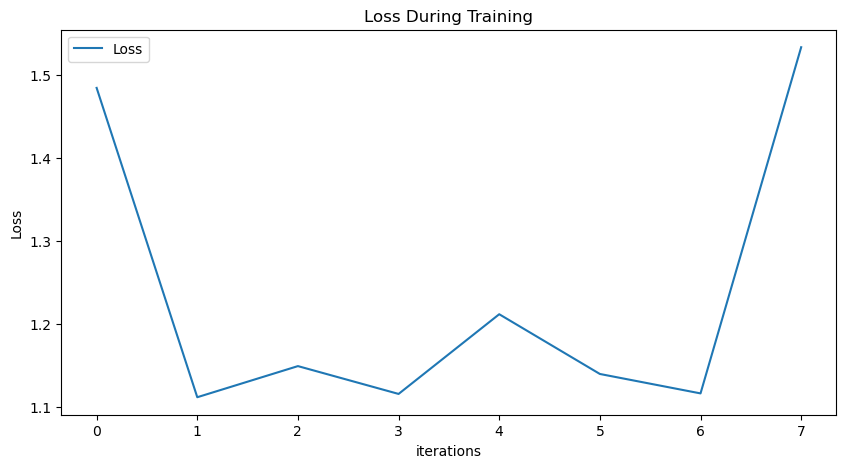

In [ ]:
data_loader=dataloader(20)
gen=VAE_GAN().to(device)
discrim=Discriminator().to(device)
real_batch = next(iter(data_loader))
show_and_save("training" ,make_grid((real_batch[0]*0.5+0.5).cpu(),8))

epochs=100
lr=3e-4
alpha=0.1
gamma=15

criterion=nn.BCELoss().to(device)
optim_E=torch.optim.RMSprop(gen.encoder.parameters(), lr=lr)
optim_D=torch.optim.RMSprop(gen.decoder.parameters(), lr=lr)
optim_Dis=torch.optim.RMSprop(discrim.parameters(), lr=lr*alpha)
z_fixed=Variable(torch.randn((64,128))).to(device)
x_fixed=Variable(real_batch[0]).to(device)

for epoch in range(epochs):
  prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
  dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
  for i, (data,_) in enumerate(data_loader, 0):
    bs=data.size()[0]
    
    ones_label=Variable(torch.ones(bs,1)).to(device)
    zeros_label=Variable(torch.zeros(bs,1)).to(device)
    zeros_label1=Variable(torch.zeros(10,1)).to(device)
    datav = Variable(data).to(device)
    mean, logvar, rec_enc = gen(datav)
    z_p = Variable(torch.randn(10,128)).to(device)
    x_p_tilda = gen.decoder(z_p)
 
    output = discrim(datav)[0]
    errD_real = criterion(output, ones_label)
    dis_real_list.append(errD_real.item())
    output = discrim(rec_enc)[0]
    errD_rec_enc = criterion(output, zeros_label)
    dis_fake_list.append(errD_rec_enc.item())
    output = discrim(x_p_tilda)[0]
    errD_rec_noise = criterion(output, zeros_label1)
    dis_prior_list.append(errD_rec_noise.item())
    gan_loss = errD_real + errD_rec_enc + errD_rec_noise
    gan_loss_list.append(gan_loss.item())
    optim_Dis.zero_grad()
    gan_loss.backward(retain_graph=True)
    optim_Dis.step()


    output = discrim(datav)[0]
    errD_real = criterion(output, ones_label)
    output = discrim(rec_enc)[0]
    errD_rec_enc = criterion(output, zeros_label)
    output = discrim(x_p_tilda)[0]
    errD_rec_noise = criterion(output, zeros_label1)
    gan_loss = errD_real + errD_rec_enc + errD_rec_noise
    

    x_l_tilda = discrim(rec_enc)[1]
    x_l = discrim(datav)[1]
    rec_loss = ((x_l_tilda - x_l) ** 2).mean()
    err_dec = gamma * rec_loss - gan_loss 
    recon_loss_list.append(rec_loss.item())
    optim_D.zero_grad()
    err_dec.backward(retain_graph=True)
    optim_D.step()
    
    mean, logvar, rec_enc = gen(datav)
    x_l_tilda = discrim(rec_enc)[1]
    x_l = discrim(datav)[1]
    rec_loss = ((x_l_tilda - x_l) ** 2).mean()
    prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
    prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
    prior_loss_list.append(prior_loss.item())
    err_enc = prior_loss + 5*rec_loss

    optim_E.zero_grad()
    err_enc.backward(retain_graph=True)
    optim_E.step()
    
    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %0.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f'
                  % (epoch,epochs, i, len(data_loader),
                     gan_loss.item(), prior_loss.item(),rec_loss.item(),errD_real.item(),errD_rec_enc.item(),errD_rec_noise.item()))

  b=gen(x_fixed)[2]
  b=b.detach()
  c=gen.decoder(z_fixed)
  c=c.detach()
  show_and_save('noise_epoch_%d.png' % epoch ,make_grid((c*0.5+0.5).cpu(),8))
  show_and_save('epoch_%d.png' % epoch ,make_grid((b*0.5+0.5).cpu(),8))
  
plot_loss(prior_loss_list)
plot_loss(recon_loss_list)
plot_loss(gan_loss_list)
plot_loss(prior_loss_list)
plot_loss(recon_loss_list)
plot_loss(gan_loss_list)

## WITH FID

Turns out testing with FID in this case is irrelevant because the model only genrates 20 images while the dataset is around 140 images

In [13]:
data_loader=dataloader(20)
gen=VAE_GAN().to(device)
discrim=Discriminator().to(device)
real_batch = next(iter(data_loader))
show_and_save("training" ,make_grid((real_batch[0]*0.5+0.5).cpu(),8))

epochs=100
lr=3e-4
alpha=0.1
gamma=15

criterion=nn.BCELoss().to(device)
optim_E=torch.optim.RMSprop(gen.encoder.parameters(), lr=lr)
optim_D=torch.optim.RMSprop(gen.decoder.parameters(), lr=lr)
optim_Dis=torch.optim.RMSprop(discrim.parameters(), lr=lr*alpha)
z_fixed=Variable(torch.randn((64,128))).to(device)
x_fixed=Variable(real_batch[0]).to(device)

for epoch in range(epochs):
  prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
  dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
  fid_scores=[]
  for i, (data,_) in enumerate(data_loader, 0):
    bs=data.size()[0]
    
    ones_label=Variable(torch.ones(bs,1)).to(device)
    zeros_label=Variable(torch.zeros(bs,1)).to(device)
    zeros_label1=Variable(torch.zeros(10,1)).to(device)
    datav = Variable(data).to(device)
    mean, logvar, rec_enc = gen(datav)
    z_p = Variable(torch.randn(10,128)).to(device)
    x_p_tilda = gen.decoder(z_p)
 
    output = discrim(datav)[0]
    errD_real = criterion(output, ones_label)
    dis_real_list.append(errD_real.item())
    output = discrim(rec_enc)[0]
    errD_rec_enc = criterion(output, zeros_label)
    dis_fake_list.append(errD_rec_enc.item())
    output = discrim(x_p_tilda)[0]
    errD_rec_noise = criterion(output, zeros_label1)
    dis_prior_list.append(errD_rec_noise.item())
    gan_loss = errD_real + errD_rec_enc + errD_rec_noise
    gan_loss_list.append(gan_loss.item())
    optim_Dis.zero_grad()
    gan_loss.backward(retain_graph=True)
    optim_Dis.step()


    output = discrim(datav)[0]
    errD_real = criterion(output, ones_label)
    output = discrim(rec_enc)[0]
    errD_rec_enc = criterion(output, zeros_label)
    output = discrim(x_p_tilda)[0]
    errD_rec_noise = criterion(output, zeros_label1)
    gan_loss = errD_real + errD_rec_enc + errD_rec_noise
    

    x_l_tilda = discrim(rec_enc)[1]
    x_l = discrim(datav)[1]
    rec_loss = ((x_l_tilda - x_l) ** 2).mean()
    err_dec = gamma * rec_loss - gan_loss 
    recon_loss_list.append(rec_loss.item())
    optim_D.zero_grad()
    err_dec.backward(retain_graph=True)
    optim_D.step()
    
    mean, logvar, rec_enc = gen(datav)
    x_l_tilda = discrim(rec_enc)[1]
    x_l = discrim(datav)[1]
    rec_loss = ((x_l_tilda - x_l) ** 2).mean()
    prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
    prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
    prior_loss_list.append(prior_loss.item())
    err_enc = prior_loss + 5*rec_loss

    b=gen(x_fixed)[2]
    b=b.detach()
    c=gen.decoder(z_fixed)
    c=c.detach()

    real = scale_images(data, (128,128,3))
    fake = scale_images(b.cpu(), (128,128,3))
    fid_score = calculate_fid(model, real, fake)
    fid_scores.append(fid_score)
    
    optim_E.zero_grad()
    err_enc.backward(retain_graph=True)
    optim_E.step()

    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %0.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f\tFID: %.4f'
                  % (epoch,epochs, i, len(data_loader),
                     gan_loss.item(), prior_loss.item(),rec_loss.item(),errD_real.item(),errD_rec_enc.item(),errD_rec_noise.item(), fid_score))


  show_and_save('noise_epoch_%d.png' % epoch ,make_grid((c*0.5+0.5).cpu(),8))
  show_and_save('epoch_%d.png' % epoch ,make_grid((b*0.5+0.5).cpu(),8))
  
plot_loss(prior_loss_list)
plot_loss(recon_loss_list)
plot_loss(gan_loss_list)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1/1 [==============================] - 0s 34ms/step
[0/100][0/8]	Loss_gan: 3.6347	Loss_prior: 0.1393	Rec_loss: 0.6321	dis_real_loss: 1.4314	dis_fake_loss: 1.1254	dis_prior_loss: 1.0780	FID: 3436.0511
1/1 [==============================] - 0s 29ms/step
[1/100][0/8]	Loss_gan: 2.0063	Loss_prior: 0.5504	Rec_loss: 0.2737	dis_real_loss: 0.6849	dis_fake_loss: 0.6639	dis_prior_loss: 0.6574	FID: 3028.0654
1/1 [==============================] - 0s 34ms/step
[2/100][0/8]	Loss_gan: 1.9948	Loss_prior: 0.3423	Rec_loss: 0.2110	dis_real_loss: 0.7295	dis_fake_loss: 0.6291	dis_prior_loss: 0.6362	FID: 3019.4693
1/1 [==============================] - 0s 31ms/step
[3/100][0/8]	Loss_gan: 1.9569	Loss_prior: 0.1900	Rec_loss: 0.1864	dis_real_loss: 0.7368	dis_fake_loss: 0.6118	dis_prior_loss: 0.6083	FID: 2942.8041
1/1 [==============================] - 0s 28ms/step
[4/100][0/8]	Loss_gan: 1.9134	Loss_prior: 0.1604	Rec_loss: 0.2009	dis_real_loss: 0.7528	dis_fake_loss: 0.5797	dis_prior_loss: 0.5808	FID: 2774.0827


KeyboardInterrupt: ignored

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>